## Gradient descent for linear SVM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

mnist_train = pd.read_csv("mnist_train.csv", header=None)
mnist_test = pd.read_csv("mnist_test.csv", header = None)
n,d = mnist_train.shape
ntest, dtest = mnist_test.shape


y_train = mnist_train.iloc[:,0]
X_train = mnist_train.iloc[:,1:]
X_train /= 255
X_train = np.array(X_train)

y_test = mnist_test.iloc[:,0]
X_test = mnist_test.iloc[:,1:]
X_test /= 255
X_test = np.array(X_test)


y_train = 2*np.array(y_train == 0)-1 # binary classification 
y_test = 2*np.array(y_test == 0)-1

### Useful functions

In [2]:
def hingereg(x, a, b, lamb):
    threshold = np.multiply(np.dot(a,x), b) 
    cost = np.maximum(1 - threshold,0)
    return cost.mean() + lamb*np.dot(x.T,x)/2

In [3]:
def gradreg(x, a, b, lamb):
    n,d = a.shape
    threshold = np.multiply(np.dot(a,x) , b)
    grad = -np.multiply(a, b.reshape(b.shape[0],1))
    idx_zeros = (threshold >= 1)
    grad[idx_zeros,:] = np.zeros(d)
    return grad.sum(axis=0)/n + lamb*x

In [4]:
def GD(a, b, init, iters, cost, grad, lamb, X_test = None, y_test = None):

    start_time = time.time()

    params = []
    costs = []
    test_scores = []
    params.append(init)
    
    for i in range(iters):
        eta = lamb/np.sqrt(i+1) 
        p = params[-1] - eta * grad(params[-1], a, b, lamb)
        params.append(p)
        c = cost(p, a, b, lamb)
        costs.append(c)
        test_score = (np.multiply(np.matmul(X_test,p), y_test) > 0).mean() 
        test_scores.append(test_score)
     
    
    end_time = time.time()
    print("Time of execution : %s seconds" % (end_time - start_time))  
        
    return params, costs, np.array(test_scores)

### Learning for MNIST

In [5]:
x0 = np.zeros(784)
niter = 150
params, costs, test_scores = GD(X_train, y_train, x0, iters=niter, cost = hingereg, grad = gradreg, lamb=(1/3), X_test=X_test, y_test=y_test)

Time of execution : 71.43273305892944 seconds


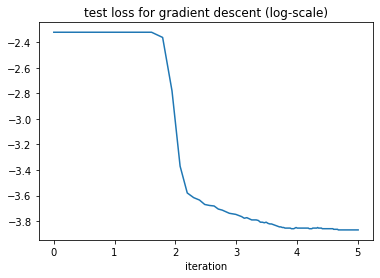

In [7]:
plt.plot(np.log(range(1, niter+1)), np.log(1-test_scores))
lm = LinearRegression()
lm.fit(np.log(range(1, niter+1)).reshape(niter,1), np.log(1-test_scores))
plt.title("test loss for gradient descent (log-scale)")
plt.xlabel("iteration")
regCoeff = lm.coef_[0]
plt.show()

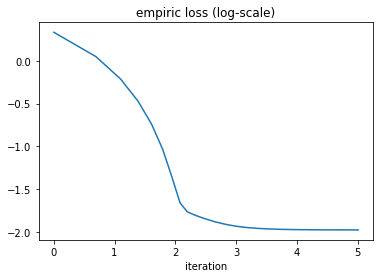

Estimated convergence rate :  -0.25940640559729683


In [10]:
plt.plot(np.log(list(range(1,niter+1))), np.log(costs))
plt.title("empiric loss (log-scale)")
plt.xlabel("iteration")
plt.show()

lm = LinearRegression()
lm.fit(np.log(range(1,niter+1)).reshape(niter,1), np.log(costs))
print("Estimated convergence rate : ",lm.coef_[0])

#### Projection on simplex

In [11]:
def proj_simplex(x, z=1):

    d = x.shape[0]
    x_sorted = -np.sort(-x) 
    x_cumsum = np.cumsum(x_sorted)
    find = x_sorted - (1/np.arange(1,d+1,1))*(x_cumsum - z)
    d0 = np.argmax(find <= 0)
    theta_star = (1/d0)*(x_cumsum[d0-1] - z)

    return np.maximum(x-theta_star,0)


def proj_l1(x, z=1):
    x_abs = np.absolute(x)
    if (np.sum(x_abs) > z):
        p_simplex = proj_simplex(x_abs, z)
        sgn = 2*(x>0)-1
        x = np.multiply(sgn, p_simplex)    
    return x

In [12]:
def projected_GD(a, b, init, iters, cost,  grad, lamb, X_test = None, y_test = None, z=10):

    start_time = time.time()
    params = []
    costs = []
    test_scores = []
    params.append(init)
    
    for i in range(iters):
        eta = lamb/np.sqrt(i+1) 
        y = params[-1] - eta * grad(params[-1], a, b, lamb)
        p = proj_l1(y, z)
        params.append(p)
        c = cost(p, a, b, lamb)
        costs.append(c)
        test_score = (np.multiply(np.matmul(X_test,p), y_test) > 0).mean() 
        test_scores.append(test_score)
       
    
    end_time = time.time()
    print("Time of execution : %s seconds" % (end_time - start_time))   
    
    return params, costs, np.array(test_scores)

In [13]:
x0 = np.zeros(784)
niter = 150 
z=10
params_proj, costs_proj, test_scores_proj = projected_GD(X_train, y_train, x0, iters=niter, cost = hingereg, grad = gradreg, lamb=(1/3), X_test=X_test, y_test=y_test, z=z)

Time of execution : 78.8378336429596 seconds


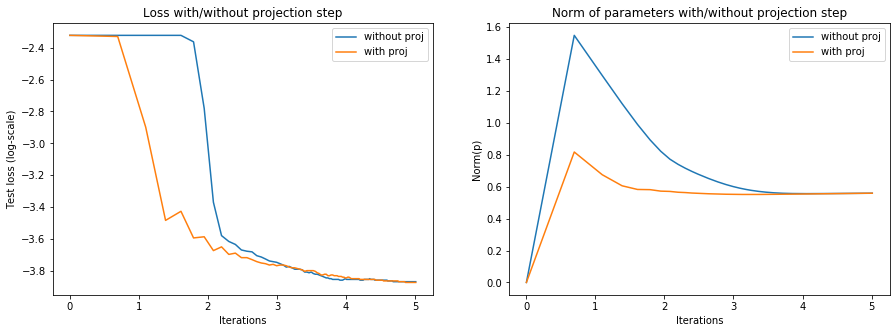

In [14]:
# Comparaison with/without projection
norm_proj = [np.linalg.norm(params_proj[i]) for i in range(niter)]
norm_ = [np.linalg.norm(params[i]) for i in range(niter)]

# Test scores convergence
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(np.log(range(1, niter+1)), np.log(1-test_scores), label = "without proj")
plt.plot(np.log(range(1, niter+1)), np.log(1-test_scores_proj), label = "with proj")
plt.xlabel("Iterations")
plt.ylabel("Test loss (log-scale)")
plt.title("Loss with/without projection step")
plt.legend()

# Norm of parameters
plt.subplot(1,2,2)
plt.plot(np.log(range(1, niter+1)), norm_, label = "without proj")
plt.plot(np.log(range(1, niter+1)), norm_proj, label = "with proj")
plt.title("Norm of parameters with/without projection step")
plt.xlabel("Iterations")
plt.ylabel("Norm(p)")
plt.legend()

#plt.savefig("GD_comparaisons.png")
plt.show()